In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
im = cv2.imread('lena.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# 滤波

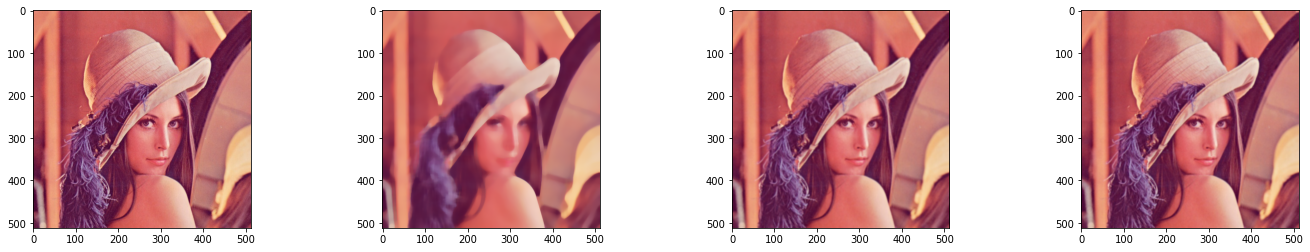

In [15]:

plt.figure(figsize=(24,4))
plt.subplot(141)
plt.imshow(im)

#中值滤波
plt.subplot(142)
im_medianblur = cv2.medianBlur(im, 15)
plt.imshow(im_medianblur)

#高斯滤波
im_gaussianblur2 = cv2.GaussianBlur(im, (5, 5), 0)
plt.subplot(143)
plt.imshow(im_gaussianblur2)

#均值滤波
im_meanblur1 = cv2.blur(im, (3, 3))
plt.subplot(144)
plt.imshow(im_meanblur1)


# 算数均值滤波

In [ ]:
def a_mean(img, kernel_size):
  G_mean_img = np.zeros(img.shape)
  k = int((kernel_size - 1) / 2)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if i < k or i > (img.shape[0] - k - 1) or j < k or j > (img.shape[1] - k - 1):
        G_mean_img[i][j] = img[i][j]
      else:
        for n in range(kernel_size):
          for m in range(kernel_size):
            G_mean_img[i][j] += float(1 / (kernel_size * kernel_size) * img[i - k + n][j - k + m])
  G_mean_img = np.uint8(G_mean_img)
  return G_mean_img

# 几何均值滤波

In [ ]:
def b_mean(img, kernel_size):
  G_mean_img = np.ones(img.shape)
  k = int((kernel_size - 1) / 2)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if i < k or i > (img.shape[0] - k - 1) or j < k or j > (img.shape[1] - k - 1):
        G_mean_img[i][j] = img[i][j]
      else:
        for n in range(kernel_size):
          for m in range(kernel_size):
            G_mean_img[i][j] *= float(img[i - k + n][j - k + m])
        G_mean_img[i][j] = pow(G_mean_img[i][j], 1 / (kernel_size * kernel_size))
  G_mean_img = np.uint8(G_mean_img)
  return G_mean_img


# 逆调和均值滤波

In [ ]:
def d_mean(img, kernel_size, Q):
  G_mean_img = np.zeros(img.shape)
  k = int((kernel_size - 1) / 2)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if i < k or i > (img.shape[0] - k - 1) or j < k or j > (img.shape[1] - k - 1):
        G_mean_img[i][j] = img[i][j]
      else:
        result_top = 0
        result_down = 0
        for n in range(kernel_size):
          for m in range(kernel_size):
            if Q > 0:
              result_top += pow(float(img[i - k + n][j - k + m]), Q + 1)
              result_down += pow(float(img[i - k + n][j - k + m]), Q)
            else:
              if img[i - k + n][j - k + m] == 0:
                G_mean_img[i][j] = 0
                break
              else:
                result_top += pow(float(img[i - k + n][j - k + m]), Q + 1)
                result_down += pow(float(img[i - k + n][j - k + m]), Q)
          else:
            continue
          break
        else:
          if result_down != 0:
            G_mean_img[i][j] = result_top / result_down
  G_mean_img = np.uint8(G_mean_img)
  return G_mean_img

imgb = d_mean(img[:,:,0],3,1)

# 频域滤波

In [ ]:
# 傅里叶变换
dft = cv2.dft(np.float32(im), flags = cv2.DFT_COMPLEX_OUTPUT)
# 将图像中的低频部分移动到图像的中心
dftShift = np.fft.fftshift(dft)
# 计算幅频特性
magnitude = 20 * np.log(cv2.magnitude(dftShift[:, :, 0], dftShift[:, :, 1]))
plt.subplot(121), plt.imshow(im, cmap = 'gray')
plt.title('原图'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude, cmap = 'gray')
plt.title('频谱图'), plt.xticks([]), plt.yticks([])
plt.show()

def mask(img, ftype):
  crow, ccol = int(img.shape[0] / 2), int(img.shape[1] / 2) # 求得图像的中心点位置
  # 低通
  if ftype == 'low':
    mask = np.zeros((img.shape[0], img.shape[1], 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
  # 高通
  if ftype == 'high':
    mask = np.ones((img.shape[0], img.shape[1], 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 0
  return mask

'''
低通
'''
highImg = dftShift * mask(im, 'high')
highImg = np.fft.ifftshift(highImg)
highImg = cv2.idft(highImg)
highImg = cv2.magnitude(highImg[:, :, 0], highImg[:, :, 1])

'''
高通
'''
highImg = dftShift * mask(grayImg, 'high')
highImg = np.fft.ifftshift(highImg)
highImg = cv2.idft(highImg)
highImg = cv2.magnitude(highImg[:, :, 0], highImg[:, :, 1])

# 8邻域降噪

In [ ]:
def noise_remove_cv2(img, k):
  def calculate_noise_count(img_obj, w, h):
    count = 0
    width, height = img_obj.shape
    for _w_ in [w - 1, w, w + 1]:
      for _h_ in [h - 1, h, h + 1]:
        if _w_ > width - 1:
          continue
        if _h_ > height - 1:
          continue
        if _w_ == w and _h_ == h:
          continue
        if img_obj[_w_, _h_] < 230:  # 二值化的图片设置为255
          count += 1
    return count
  # 灰度
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  w, h = gray_img.shape
  for _w in range(w):
    for _h in range(h):
      if _w == 0 or _h == 0:
        gray_img[_w, _h] = 255
        continue
      # 计算邻域pixel值小于255的个数
      pixel = gray_img[_w, _h]
      if pixel == 255:
        continue
      if calculate_noise_count(gray_img, _w, _h) < k:
        gray_img[_w, _h] = 255
  return gray_img
imgb = noise_remove_cv2(im,4)
plt.figure(figsize=(20,5))
plt.imshow(imgb,cmap='gray')
plt.show()

# 锐化

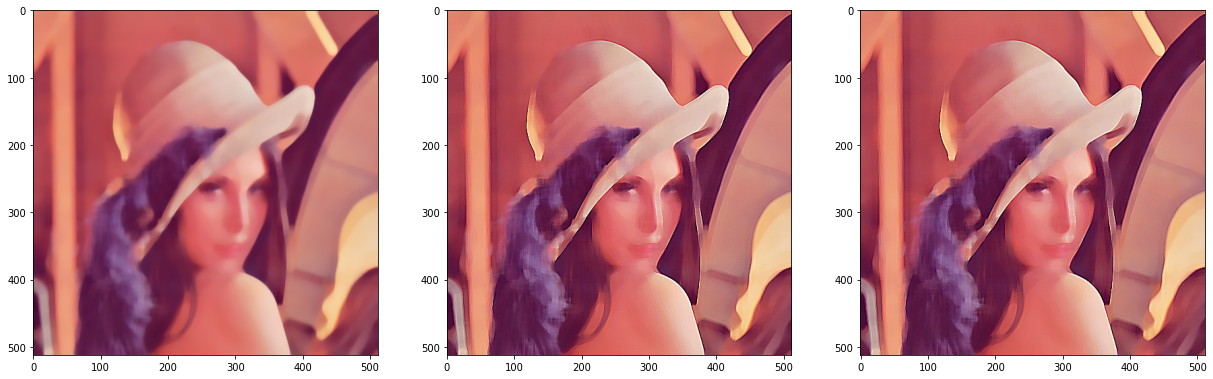

In [19]:
plt.figure(figsize=(21,7))
plt.subplot(131)
plt.imshow(im_medianblur)

sharpen_1 = np.array([
  [-1,-1,-1],
  [-1,9,-1],
  [-1,-1,-1]])

#使用filter2D进行滤波操作
im_sharpen1 = cv2.filter2D(im_medianblur,-1,sharpen_1)
plt.subplot(132)
plt.imshow(im_sharpen1)

#锐化算子2
sharpen_2 = np.array([
[0,-1,0],
[-1,8,-1],
[0,1,0]])/4.0

#使用filter2D进行滤波操作
im_sharpen2 = cv2.filter2D (im_medianblur, -1, sharpen_2)
plt.subplot(133)
plt.imshow(im_sharpen1)